# **Sesión 3: Procesamiento Avanzado de Imágenes** ⚙️🖼️

## **Instalaciones**

In [1]:
!pip install tqdm scikit-learn openpyxl pandas matplotlib

## **Librerías**

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from utils import *
from bow import BoW
from dataset import Dataset
from image_classifier import ImageClassifier
import time
from tqdm import tqdm
import sys
import pickle
import os

# **Apartado C**: Detección de puntos de interés y Bolsa de palabras

## **C1: Detección de puntos de interés**

### **Tarea C.1.1**: Generar función de filtro gaussiano

Se generará a partir de la imagen base las imágenes con el filtrado gaussiano. Para ello se empleará la función `generateGaussianImages()` que tiene que desarrollar empleando la función [`cv2.GaussianBlur()`](https://docs.opencv.org/4.x/d4/d86/group__imgproc__filter.html#gae8bdcd9154ed5ca3cbc1766d960f45c1). Es recomendble visualizar los resultados para comprobar el funcionamiento. Para ello convierta los datos de la imagen a visualizar a `np.uint8`

In [5]:
def generateGaussianImages(image, sigmas):
    """Generate the gaussian images using the base image and the sigmas given

    Args:
        image (np.array[np.float32]): Base image to blur
        sigmas (List[np.float32]): Sigmas for blurring the image 

    Returns:
        List[np.array[np.float32]: List of blurred images
    """
    gaussian_images = []

    # TODO: Generate the list of blurred images using cv2.GaussianBlur()
    for sigma in sigmas:
        image = cv2.GaussianBlur(image, (5, 5), sigma)
        gaussian_images.append(image)
    
    return gaussian_images
    

### **Tarea C.1.2**: Generación de espacio de escalas con imágenes gaussianas

Empleando la función anterior, complete la siguiente celda para generar las imágenes gaussianas

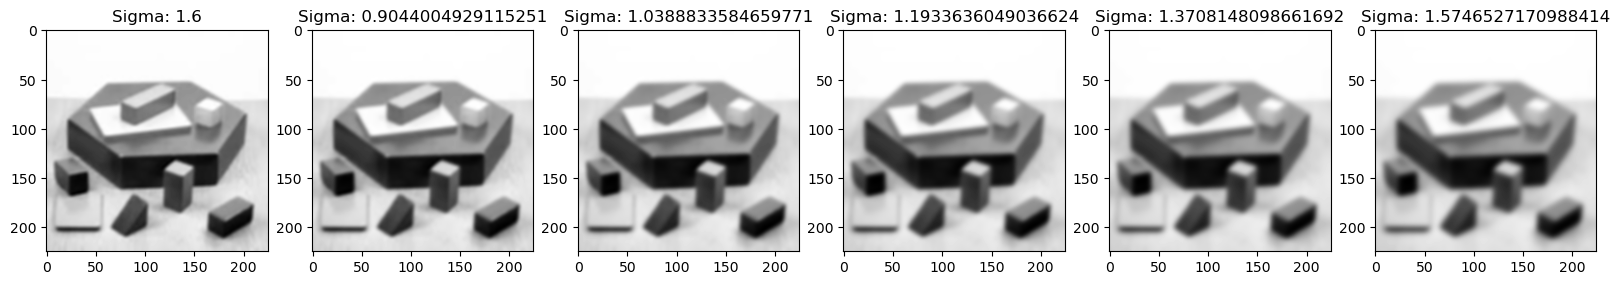

In [4]:
#TODO: Load the image in grayscale
data_path = "../data"
image = cv2.imread(os.path.join(data_path, "0.jpg"), cv2.IMREAD_GRAYSCALE)
image = image.astype(np.float32)
# Number of diference of gaussians to generate (minimum 3)
# TODO: Adjust this number to make sure keypoints are generated
intervals = 5
# Initial sigma
sigma = 1.6 
# We get the necessary sigmas from the given method generateGaussianSigmas()
sigmas = generateGaussianSigmas(sigma, intervals)
#TODO: Generate the gaussian images
gaussian_images = generateGaussianImages(image, sigmas)

# Show the images
plt.figure(figsize=(20, 20))
for i, img in enumerate(gaussian_images):
	plt.subplot(1, len(gaussian_images), i+1)
	plt.imshow(img, cmap='gray')
	plt.title(f"Sigma: {sigmas[i]}")

### **Tarea C.1.3**: Generación de diferencias de gaussianas

Utilizando la lista de imágenes gaussianas se generará una lista con las diferencias entre pares consegutivos. Para ello se empleará la función `generateDoGImages()` que tiene que desarrollar empleando la función [`cv2.subtract()`](https://docs.opencv.org/4.x/d2/de8/group__core__array.html#gaa0f00d98b4b5edeaeb7b8333b2de353b)

In [6]:
def generateDoGImages(gaussian_images):
	"""Generate Difference-of-Gaussians list

	Args:
		gaussian_images (List[np.array[np.float32]): List of blurred images

	Returns:
		List[np.array[np.float32]: List of difference of gaussian images
	"""
	dog_images = []

    # TODO: Generate the list of difference of gaussians using cv2.subtract()
	for i in range(1, len(gaussian_images)):
		dog_img = cv2.subtract(gaussian_images[i], gaussian_images[i-1])
		dog_images.append(dog_img) 
    
	return dog_images

dog_images = generateDoGImages(gaussian_images)

# Show the images
for img in dog_images:
	cv2.imshow("DoG", img)
	cv2.waitKey(0)
	cv2.destroyAllWindows()

### **Tarea C.1.4**: Evaluación de extremos

La función `isPixelAnExtremum()` debe evaluar si el pixel central del bloque compuesto por las regiones de las 3 imágenes es un máximo o mínimo entre ellos. Como prevención, tenga en cuenta que puede tomar valores positivos y negativos

In [7]:
def isPixelAnExtremum(first_subimage, second_subimage, third_subimage, threshold):
	"""Return True if the center element of the 3x3x3 array composed of subimages is strictly greater than or less than all its neighbors, False otherwise

	Args:
		first_subimage (np.array): Patch from first gaussian
		second_subimage (np.array): Patch from second gaussian
		third_subimage (np.array): Patch from third gaussian
		threshold (float): Value threshold for the pixel

	Returns:
		Bool: True if maximum or minimum, False otherwise
	"""
	extremum = False
    # TODO: Check if the center pixel value is a maximum or a minimum and if its absolute value is higher than the threshold
	center = second_subimage[1, 1]
	
	if abs(center) > threshold:
		if center > 0:
			extremum = (center >= np.max(first_subimage)) and (center >= np.max(third_subimage)) and (center >= np.max(second_subimage))
		else:
			extremum = (center <= np.min(first_subimage)) and (center <= np.min(third_subimage)) and (center >= np.max(second_subimage))

	return extremum

In [8]:
first_subimage = np.zeros((3,3),np.float32)
third_subimage = np.zeros((3,3),np.float32)
second_subimage = np.ones((3,3),np.float32)
isPixelAnExtremum(first_subimage,second_subimage, third_subimage, 0.03)

True

### **Tarea C.1.5**: Localización de puntos clave y orientación de los mismos

La función `findScaleSpaceExtrema()` obtendrá los puntos clave y su orientación a partir de las gaussianas y sus diferencias empleando, entre otras, la función `isPixelAnExtremum()`. Deberá completar las partes indicadas para recorrer todos los trios de imágenes consecutivos y evaluar los píxeles necesarios de estos.

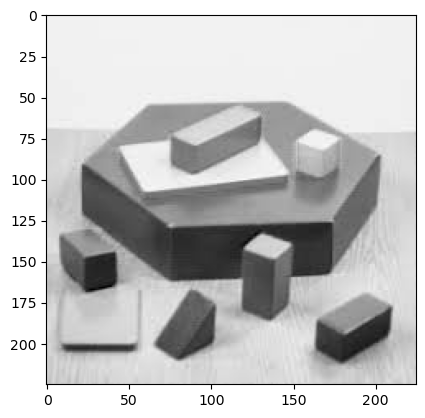

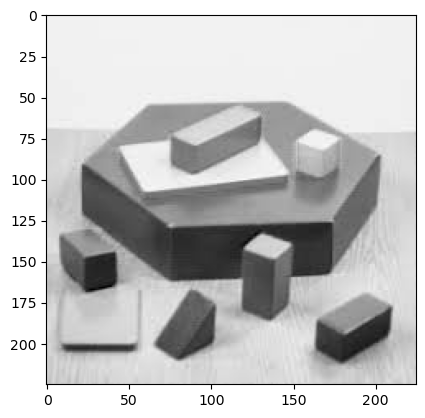

In [9]:
def findScaleSpaceExtrema(gaussian_images, dog_images, num_intervals, sigma, threshold=0.03):
    """Find pixel positions of all scale-space extrema in the image pyramid """
    keypoints = []

    # TODO: Fill the loop source data
    for image_index, (first_image, second_image, third_image) in enumerate(zip(dog_images, dog_images[1:], dog_images[2:])):
        # (i, j) is the center of the 3x3 array
        # TODO: Fill the 2 range limits knowing you have to move the 3x3 window across the whole image
        for i in range(1, len(second_image) - 1):
            for j in range(1, len(second_image[0]) - 1):
                # TODO: Fill the method with the required arguments
                first_subimage = first_image[i-1:i+2, j-1:j+2]
                second_subimage = second_image[i-1:i+2, j-1:j+2]
                third_subimage = third_image[i-1:i+2, j-1:j+2]

                if isPixelAnExtremum(first_subimage, second_subimage, third_subimage, threshold):
                    # Refine the keypoint localization
                    localization_result = localizeExtremumViaQuadraticFit(i, j, image_index + 1, num_intervals, dog_images, sigma)
                    
                    if localization_result is not None:
                        keypoint, localized_image_index = localization_result
                        # Get the keypoint orientation
                        keypoints_with_orientations = computeKeypointsWithOrientations(keypoint, gaussian_images[localized_image_index])
                        for keypoint_with_orientation in keypoints_with_orientations:
                            keypoints.append(keypoint_with_orientation)
    return keypoints

# Keypoint Detection with Taylor Expansion and Contrast Thresholding
threshold = 0.03
keypoints = findScaleSpaceExtrema(gaussian_images, dog_images, intervals, sigma, threshold)
visualizeKp(image, keypoints)
keypoints = removeDuplicateKeypoints(keypoints)
visualizeKp(image, keypoints)

Tengo todo supuestamente bien pero no detecta ningún keypoint, he intentado solucionarlo y pregunté la duda pero sigo sin saber qué hay mal.

Con los puntos clave totalmente definidos y las imágenes gaussianas ya podemos obtener los descriptores con la función proporcionada de `generateDescriptors()`

In [9]:
descriptors = generateDescriptors(keypoints, gaussian_images)

### **Tarea C.1.6**: Pipeline de generación de puntos clave y descriptores

Complete la función con los métodos desarrollados en tareas previas para generar los puntos clave y descriptores necesarios dada una imagen, un valor de sigma y un número de diferencias de gaussianas

In [10]:
def computeKeypointsAndDescriptors(image, sigma=1.6, num_intervals=5):
    """Compute SIFT keypoints and descriptors for an input image """
    # TODO: Fill the pipeline to get the keypoint and descriptors as before
    image = image.astype('float32')
    gaussian_kernels = generateGaussianSigmas(sigma, num_intervals)
    gaussian_images = generateGaussianImages(image, gaussian_kernels)
    dog_images = generateDoGImages(gaussian_images)
    keypoints = findScaleSpaceExtrema(gaussian_images, dog_images, num_intervals, sigma)
    descriptors = generateDescriptors(keypoints, gaussian_images)
    return keypoints, descriptors

### **Tarea C.1.7**: Correspondencia de características entre imágenes

Cargue las imágenes con `cv2` y complete la llamada a la función previa

In [11]:
# TODO: Load the images with cv2 in grayscale
img1 = cv2.imread(os.path.join(data_path, "0.jpg"), cv2.IMREAD_GRAYSCALE)
# Same image with a rotation of 90 degrees
img2 = cv2.imread(os.path.join(data_path, "0_rot.jpg"), cv2.IMREAD_GRAYSCALE)

# TODO: Fill the function calls
kp1, des1 = computeKeypointsAndDescriptors(img1)
kp2, des2 = computeKeypointsAndDescriptors(img2)

matchFeatures(img1, kp1, des1, img2, kp2, des2)

Not enough matches are found - 0/10


#### **Ampliación**: SIFT con OpenCV

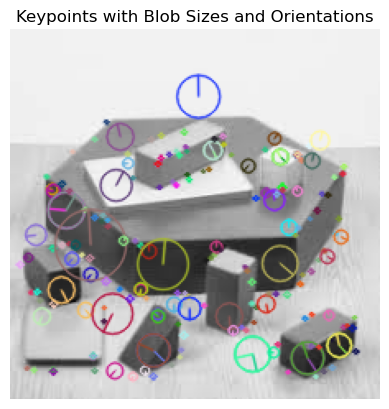

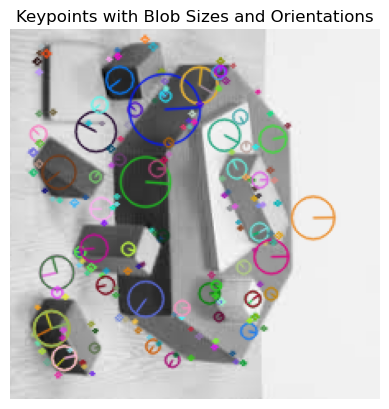

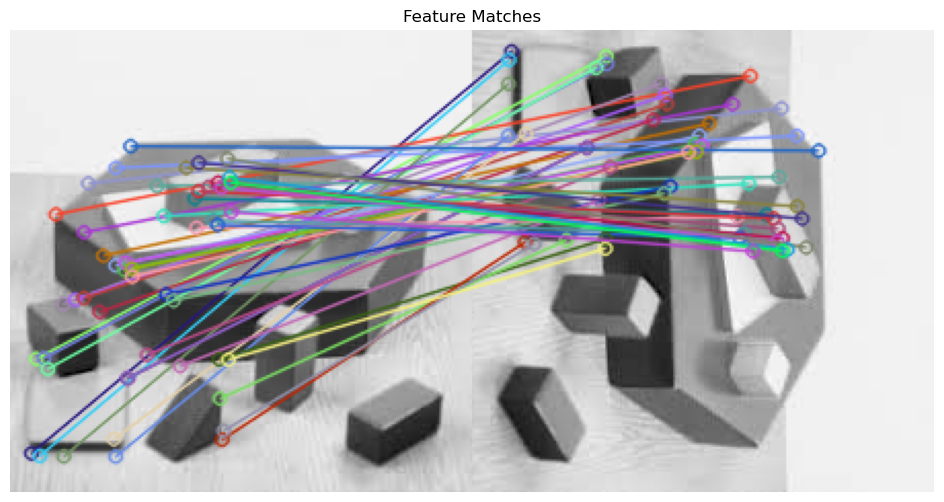

In [12]:
# Load the image
image_0 = cv2.imread('../data/0.jpg', cv2.IMREAD_GRAYSCALE)
image_1 = cv2.imread('../data/0_rot.jpg', cv2.IMREAD_GRAYSCALE)

# Create a SIFT detector object
sift = cv2.SIFT_create()

# Detect keypoints and compute descriptors
keypoints_0, descriptors_0 = sift.detectAndCompute(image_0, None)
keypoints_1, descriptors_1 = sift.detectAndCompute(image_1, None)

# Draw keypoints on the image
image_with_keypoints_0 = cv2.drawKeypoints(image_0, keypoints_0, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
image_with_keypoints_1 = cv2.drawKeypoints(image_1, keypoints_1, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

plt.imshow(image_with_keypoints_0)
plt.title('Keypoints with Blob Sizes and Orientations')
plt.axis('off')
plt.show()
plt.imshow(image_with_keypoints_1)
plt.title('Keypoints with Blob Sizes and Orientations')
plt.axis('off')
plt.show()

# Initialize BFMatcher
bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=False)

# Perform KNN matching with k=2 for ratio test
matches = bf.match(descriptors_0, descriptors_1)

# sort matches by distance
matches = sorted(matches, key = lambda x:x.distance)


# Draw the good matches
matched_image = cv2.drawMatches(image_0, keypoints_0, image_1, keypoints_1, matches[:50], None,
                                flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

# Display the matched features
plt.figure(figsize=(12, 6))
plt.imshow(matched_image)
plt.title("Feature Matches")
plt.axis('off')
plt.show()

### **Pregunta C1**: Correspodencia de imágenes propias y evaluación

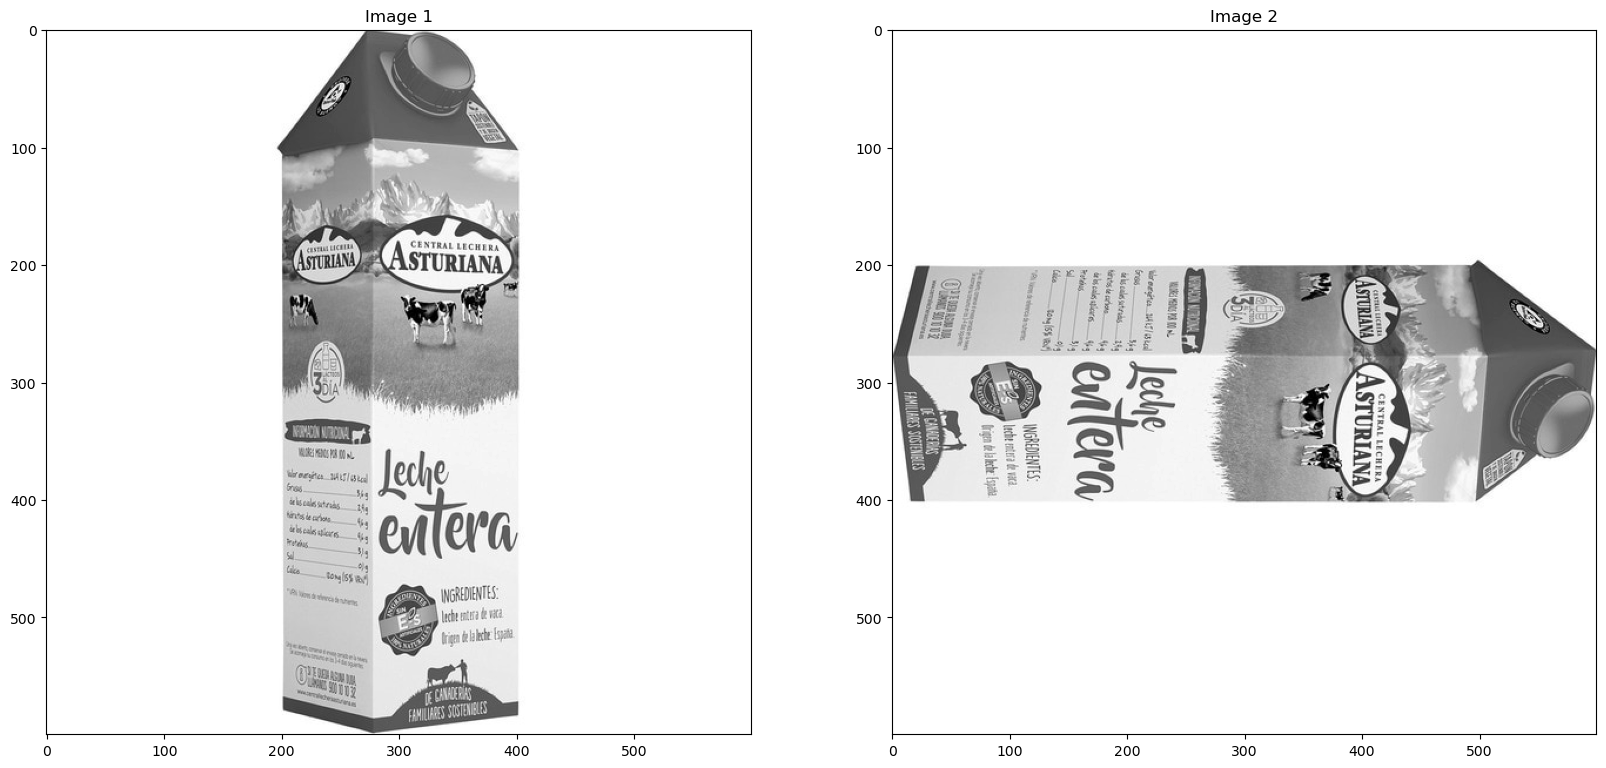

In [13]:
# TODO: Homework
img0 = cv2.imread(os.path.join("../data/partC", "0.jpg"), cv2.IMREAD_GRAYSCALE)
img1 = cv2.imread(os.path.join("../data/partC", "0.jpg"), cv2.IMREAD_GRAYSCALE)
img1 = cv2.rotate(img1, cv2.ROTATE_90_CLOCKWISE)

# Show the images
plt.figure(figsize=(20, 20))
plt.subplot(1, 2, 1)
plt.imshow(img0, cmap='gray')
plt.title("Image 1")
plt.subplot(1, 2, 2)
plt.imshow(img1, cmap='gray')
plt.title("Image 2")
plt.show()

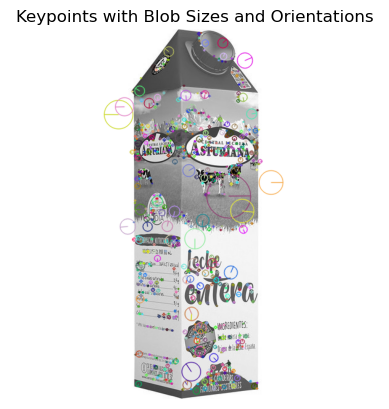

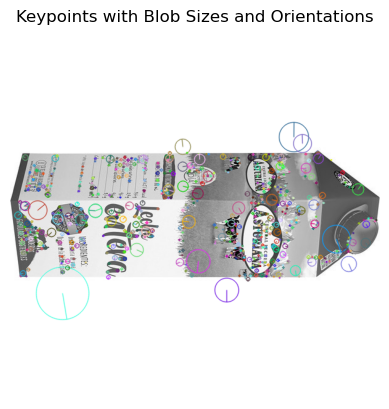

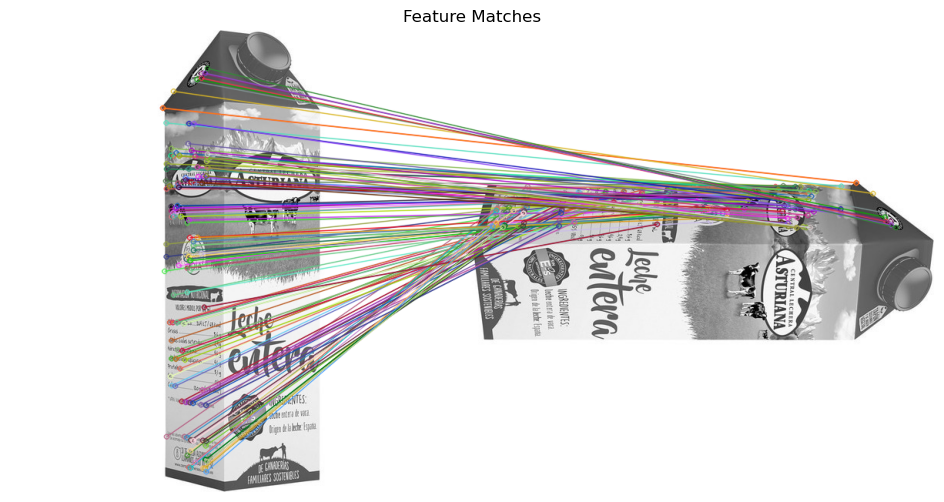

In [14]:
# Create a SIFT detector object
sift = cv2.SIFT_create()

# Detect keypoints and compute descriptors
keypoints_0, descriptors_0 = sift.detectAndCompute(img0, None)
keypoints_1, descriptors_1 = sift.detectAndCompute(img1, None)

# Draw keypoints on the image
image_with_keypoints_0 = cv2.drawKeypoints(img0, keypoints_0, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
image_with_keypoints_1 = cv2.drawKeypoints(img1, keypoints_1, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

plt.imshow(image_with_keypoints_0)
plt.title('Keypoints with Blob Sizes and Orientations')
plt.axis('off')
plt.show()
plt.imshow(image_with_keypoints_1)
plt.title('Keypoints with Blob Sizes and Orientations')
plt.axis('off')
plt.show()

# Initialize BFMatcher
bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=False)

# Perform KNN matching with k=2 for ratio test
matches = bf.match(descriptors_0, descriptors_1)
# sort matches by distance
matches = sorted(matches, key = lambda x:x.distance)


# Draw the good matches
matched_image = cv2.drawMatches(img0, keypoints_0, img1, keypoints_1, matches[:150], None,
                                flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

# Display the matched features
plt.figure(figsize=(12, 6))
plt.imshow(matched_image)
plt.title("Feature Matches")
plt.axis('off')
plt.show()

## **C2: Bolsa de palabras**

### **Tarea C.2.1**: Carga de los datasets de entrenamiento y validación para la bolsa de palabras

Empleando el método `load()` de la clase [`Dataset`](.\dataset.py) que se le proporciona, cargue los datasets de entrenamiento y validación.

In [32]:
dataset_path = "../data/dataset"
training_set = Dataset.load(os.path.join(dataset_path, "training"), ".jpg")
validation_set = Dataset.load(os.path.join(dataset_path, "validation"), ".jpg")

### **Tarea C.2.2**: Extracción de los descriptores

Para poder crear la bolsa de palabras se va a comenzar obteniendo los descriptores que serán agrupados en las distintas palabras de nuestra bolsa. Para ello complete la carga de la imagen en la ruta `path` en escala de grises y obtenga sus descriptores con los métodos apropiados de cv2. Los descriptores obtenidos se añadirán a nuestra bolsa de palabras (`words`) para después ser agrupados por palabras que representen

In [33]:
feature_extractor = cv2.SIFT_create()

# Extract features
print("\nComputing SIFT descriptors...")
time.sleep(0.1)  # Prevents a race condition between tqdm and print statements.
descriptors = []
for path in tqdm(training_set, unit="image", file=sys.stdout):
    # TODO: Load the image from the path in grayscale
    image = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    try:
        # TODO: Using the cv2 methods get the descriptors for the image
        _, descriptor = feature_extractor.detectAndCompute(image, None)
    except:
        print(f"WARN: Issue generating descriptor for image {path}")

    if descriptor is not None:
        descriptors.append(descriptor)


Computing SIFT descriptors...
100%|██████████| 2981/2981 [01:53<00:00, 26.28image/s]


### **Tarea C.2.3**: Creación del vocabulario

Añada los descriptores a la bolsa (`words`) con el método add de la misma. Con los descriptores en la bolsa, se va a realizar el agrupamiento de los mismos por palabras para obtener un vocabulario de palabras visuales. Complete la ruta de apertura del archivo y establezca el modo de apertura en escrituria y bineario para poder guardar el vocabulario generado.

In [34]:
# Build vocabulary
vocabulary_size = 100
iterations = 20
termination_criteria = (cv2.TERM_CRITERIA_MAX_ITER | cv2.TERM_CRITERIA_EPS, iterations, 1e-6)
words = cv2.BOWKMeansTrainer(vocabulary_size, termination_criteria)

# TODO: Add all descriptors
for descriptor in descriptors:
	words.add(descriptor)

time.sleep(0.1)  # Prevents a race condition between tqdm and print statements.
print("\nClustering descriptors into", vocabulary_size, "words using K-means...")
vocabulary = words.cluster()
filename=  "vocabulary.pickle"
# TODO: Open the file from above in the write and binay mode
with open(filename, 'wb') as f:
    pickle.dump(["SIFT", vocabulary], f, pickle.HIGHEST_PROTOCOL)


Clustering descriptors into 100 words using K-means...


### **Tarea C.2.4**: Entrenamiento del clasificador

Una vez se tiene el vocabulario de palabras visuales, se va a entrenar al classificador. Para ello haga uso de la clase [BoW](./bow.py) y complete los métodos que se le indican

In [35]:
bow = BoW()
# TODO: Especify the args for the loading method
bow.load_vocabulary("vocabulary")

image_classifier = ImageClassifier(bow)
# TODO: Especify the args for the training method
image_classifier.train(training_set)
classifier = "classifier"
image_classifier.save(classifier)



TRAINING CLASSIFIER

Extracting features...
100%|██████████| 2981/2981 [03:03<00:00, 16.21image/s]

Training SVM...


### **Tarea C.2.5**: Inferencia en dataset de entrenamiento
Con el modelo entrenado se procede a comprobar su desempeño con el dataset de entrenamiento. Complete los métodos indicados

In [36]:
bow = BoW()
# TODO: Especify the args for the loading method
bow.load_vocabulary("vocabulary")

image_classifier = ImageClassifier(bow)
# TODO: Especify the args for the loading method
image_classifier.load(classifier)
# TODO: Especify the args for the loading method
image_classifier.predict(training_set)



CLASSIFICATION RESULTS

Confusion matrix

KNOWN/PREDICTED  Bedroom  Coast  Forest  Highway  Industrial  Inside city  Kitchen  Living room  Mountain  Office  Open country  Store  Street  Suburb  Tall building
Bedroom             27.0    2.0     2.0      2.0        20.0          4.0      1.0         26.0       0.0     3.0           7.0    9.0     4.0     3.0            6.0
Coast                1.0  183.0     8.0      9.0         2.0          3.0      0.0          2.0      19.0     0.0          22.0    0.0     2.0     2.0            7.0
Forest               0.0    0.0   209.0      0.0         0.0          0.0      0.0          0.0       7.0     0.0           9.0    1.0     2.0     0.0            0.0
Highway              2.0   38.0     0.0     63.0         7.0          5.0      0.0          0.0       3.0     0.0          10.0    2.0    15.0     5.0           10.0
Industrial           4.0    6.0     2.0      2.0        90.0         28.0      0.0         14.0       6.0     3.0           4.

(0.5840322039584033,
 array([[ 27.,   2.,   2.,   2.,  20.,   4.,   1.,  26.,   0.,   3.,   7.,   9.,   4.,   3.,   6.],
        [  1., 183.,   8.,   9.,   2.,   3.,   0.,   2.,  19.,   0.,  22.,   0.,   2.,   2.,   7.],
        [  0.,   0., 209.,   0.,   0.,   0.,   0.,   0.,   7.,   0.,   9.,   1.,   2.,   0.,   0.],
        [  2.,  38.,   0.,  63.,   7.,   5.,   0.,   0.,   3.,   0.,  10.,   2.,  15.,   5.,  10.],
        [  4.,   6.,   2.,   2.,  90.,  28.,   0.,  14.,   6.,   3.,   4.,  17.,  15.,   8.,  12.],
        [  2.,   2.,   0.,   2.,  15., 140.,   0.,   5.,   0.,   1.,   3.,  12.,   7.,   2.,  17.],
        [  5.,   0.,   0.,   0.,  20.,  29.,  10.,  23.,   0.,  11.,   0.,   4.,   2.,   3.,   2.],
        [  8.,   1.,   0.,   0.,  21.,  11.,   2., 108.,   2.,   5.,   2.,   9.,   7.,   7.,   6.],
        [  0.,  28.,  17.,   1.,   0.,   0.,   0.,   0., 173.,   0.,  45.,   2.,   4.,   2.,   1.],
        [  7.,   0.,   0.,   0.,  12.,  19.,   1.,  33.,   0.,  32.,   0.,   3.

### **Tarea C.2.6**: Inferencia en dataset de evaluación

A continuación se evalua el desempeño del modelo con el dataset de validación. Complete los métodos indicados

In [37]:
bow = BoW()
# TODO: Especify the args for the loading method
bow.load_vocabulary("vocabulary")

image_classifier = ImageClassifier(bow)
# TODO: Especify the args for the loading method
image_classifier.load(classifier)
# TODO: Especify the args for the loading method
image_classifier.predict(validation_set)



CLASSIFICATION RESULTS

Confusion matrix

KNOWN/PREDICTED  Bedroom  Coast  Forest  Highway  Industrial  Inside city  Kitchen  Living room  Mountain  Office  Open country  Store  Street  Suburb  Tall building
Bedroom             12.0    2.0     2.0      4.0        10.0          7.0      2.0         30.0       3.0     8.0           3.0    6.0     2.0     1.0            8.0
Coast                1.0   68.0     2.0      5.0         1.0          0.0      0.0          1.0       9.0     0.0          10.0    0.0     0.0     2.0            1.0
Forest               0.0    0.0    87.0      0.0         0.0          0.0      0.0          0.0       3.0     0.0           8.0    1.0     0.0     1.0            0.0
Highway              1.0   33.0     0.0     34.0         7.0          5.0      0.0          1.0       5.0     0.0           2.0    1.0     3.0     2.0            6.0
Industrial           5.0    2.0     0.0      2.0        30.0         17.0      0.0          9.0       3.0     0.0           3.

(0.484,
 array([[12.,  2.,  2.,  4., 10.,  7.,  2., 30.,  3.,  8.,  3.,  6.,  2.,  1.,  8.],
        [ 1., 68.,  2.,  5.,  1.,  0.,  0.,  1.,  9.,  0., 10.,  0.,  0.,  2.,  1.],
        [ 0.,  0., 87.,  0.,  0.,  0.,  0.,  0.,  3.,  0.,  8.,  1.,  0.,  1.,  0.],
        [ 1., 33.,  0., 34.,  7.,  5.,  0.,  1.,  5.,  0.,  2.,  1.,  3.,  2.,  6.],
        [ 5.,  2.,  0.,  2., 30., 17.,  0.,  9.,  3.,  0.,  3.,  8., 12.,  1.,  8.],
        [ 1.,  0.,  0.,  2.,  4., 62.,  0.,  3.,  2.,  4.,  1.,  4.,  6.,  1., 10.],
        [ 7.,  0.,  1.,  0.,  6., 17.,  9., 33.,  0.,  9.,  1., 11.,  1.,  3.,  2.],
        [ 7.,  1.,  0.,  0., 12.,  5.,  2., 48.,  1.,  4.,  1.,  8.,  3.,  1.,  7.],
        [ 0.,  9.,  7.,  0.,  1.,  0.,  0.,  0., 57.,  0., 22.,  0.,  3.,  1.,  0.],
        [ 7.,  0.,  0.,  0.,  5., 21.,  0., 30.,  1., 27.,  0.,  3.,  0.,  2.,  4.],
        [ 0., 25.,  7.,  1.,  2.,  0.,  0.,  0., 13.,  0., 49.,  0.,  1.,  2.,  0.],
        [ 1.,  1.,  4.,  0.,  6.,  8.,  0.,  7.,  1.,  1.

### **Pregunta C.2.A**: Cambio de SIFT por Kaze

In [29]:
#TODO: Homework
feature_extractor = cv2.KAZE_create()

# Extract features
print("\nComputing KAZE descriptors...")
time.sleep(0.1)  # Prevents a race condition between tqdm and print statements.
descriptors = []
for path in tqdm(training_set, unit="image", file=sys.stdout):
    # TODO: Load the image from the path in grayscale
    image = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    try:
        # TODO: Using the cv2 methods get the descriptors for the image
        _, descriptor = feature_extractor.detectAndCompute(image, None)
    except:
        print(f"WARN: Issue generating descriptor for image {path}")

    if descriptor is not None:
        descriptors.append(descriptor)
        
# Build vocabulary
vocabulary_size = 100
iterations = 20
termination_criteria = (cv2.TERM_CRITERIA_MAX_ITER | cv2.TERM_CRITERIA_EPS, iterations, 1e-6)
words = cv2.BOWKMeansTrainer(vocabulary_size, termination_criteria)

# TODO: Add all descriptors
for descriptor in descriptors:
	words.add(descriptor)

time.sleep(0.1)  # Prevents a race condition between tqdm and print statements.
print("\nClustering descriptors into", vocabulary_size, "words using K-means...")
vocabulary = words.cluster()
filename=  "vocabulary_KAZE.pickle"
# TODO: Open the file from above in the write and binay mode
with open(filename, 'wb') as f:
    pickle.dump(["KAZE", vocabulary], f, pickle.HIGHEST_PROTOCOL)


Computing KAZE descriptors...
100%|██████████| 2981/2981 [03:25<00:00, 14.48image/s]

Clustering descriptors into 100 words using K-means...


In [30]:
bow = BoW()
# TODO: Especify the args for the loading method
bow.load_vocabulary("vocabulary_KAZE")

image_classifier = ImageClassifier(bow)
# TODO: Especify the args for the training method
image_classifier.train(training_set)
classifier = "classifier"
image_classifier.save(classifier)



TRAINING CLASSIFIER

Extracting features...
100%|██████████| 2981/2981 [06:08<00:00,  8.09image/s]

Training SVM...


In [31]:
bow = BoW()
# TODO: Especify the args for the loading method
bow.load_vocabulary("vocabulary_KAZE")

image_classifier = ImageClassifier(bow)
# TODO: Especify the args for the loading method
image_classifier.load(classifier)
# TODO: Especify the args for the loading method
accuracy_KAZEt, confusion_matrix_KAZEt, classification_KAZEt = image_classifier.predict(training_set)



CLASSIFICATION RESULTS

Confusion matrix

KNOWN/PREDICTED  Bedroom  Coast  Forest  Highway  Industrial  Inside city  Kitchen  Living room  Mountain  Office  Open country  Store  Street  Suburb  Tall building
Bedroom             37.0    0.0     2.0      1.0         7.0          5.0      1.0         22.0       4.0     4.0           2.0    5.0     4.0     2.0           20.0
Coast                3.0  168.0    11.0     17.0         4.0          0.0      0.0          4.0      14.0     1.0          27.0    0.0     1.0     2.0            8.0
Forest               1.0    1.0   182.0      0.0         3.0          1.0      0.0          1.0      12.0     1.0           8.0   12.0     3.0     1.0            2.0
Highway              0.0   25.0     1.0     86.0         6.0          3.0      0.0          1.0       5.0     0.0          15.0    2.0     5.0     1.0           10.0
Industrial           3.0   13.0     5.0      6.0        74.0         10.0      0.0         11.0      16.0     0.0          13.

In [ ]:
bow = BoW()
# TODO: Especify the args for the loading method
bow.load_vocabulary("vocabulary_KAZE")

image_classifier = ImageClassifier(bow)
# TODO: Especify the args for the loading method
image_classifier.load(classifier)
# TODO: Especify the args for the loading method
accuracy_KAZEv, confusion_matrix_KAZEv, classification_KAZEv = image_classifier.predict(validation_set)



CLASSIFICATION RESULTS

Confusion matrix

KNOWN/PREDICTED  Bedroom  Coast  Forest  Highway  Industrial  Inside city  Kitchen  Living room  Mountain  Office  Open country  Store  Street  Suburb  Tall building
Bedroom             20.0    0.0     5.0      1.0         5.0         10.0      1.0         37.0       1.0     1.0           1.0    3.0     3.0     4.0            8.0
Coast                0.0   52.0     5.0     13.0         0.0          1.0      0.0          0.0       8.0     1.0          16.0    0.0     0.0     0.0            2.0
Forest               0.0    0.0    69.0      0.0         2.0          0.0      0.0          0.0       6.0     0.0           6.0   12.0     1.0     0.0            4.0
Highway              0.0   20.0     0.0     47.0         3.0          4.0      0.0          0.0       3.0     1.0          17.0    0.0     4.0     1.0            0.0
Industrial           2.0    3.0     2.0      5.0        28.0          5.0      0.0          7.0       6.0     1.0           5.

(0.3871829105473965,
 array([[20.,  0.,  5.,  1.,  5., 10.,  1., 37.,  1.,  1.,  1.,  3.,  3.,  4.,  8.],
        [ 0., 52.,  5., 13.,  0.,  1.,  0.,  0.,  8.,  1., 16.,  0.,  0.,  0.,  2.],
        [ 0.,  0., 69.,  0.,  2.,  0.,  0.,  0.,  6.,  0.,  6., 12.,  1.,  0.,  4.],
        [ 0., 20.,  0., 47.,  3.,  4.,  0.,  0.,  3.,  1., 17.,  0.,  4.,  1.,  0.],
        [ 2.,  3.,  2.,  5., 28.,  5.,  0.,  7.,  6.,  1.,  5., 14.,  9.,  2., 11.],
        [ 2.,  7.,  4.,  0.,  2., 48.,  0.,  7.,  0.,  1.,  2., 16.,  2.,  1.,  8.],
        [ 3.,  1.,  2.,  2.,  9., 21.,  1., 40.,  1.,  4.,  0.,  4.,  2.,  1.,  9.],
        [ 9.,  0.,  1.,  0.,  6.,  6.,  0., 57.,  3.,  1.,  0.,  1.,  0.,  3., 13.],
        [ 0., 14.,  7.,  1.,  5.,  2.,  0.,  0., 40.,  1., 18.,  4.,  3.,  0.,  5.],
        [ 6.,  1.,  1.,  1.,  4., 14.,  0., 23.,  1., 19.,  2.,  2.,  3.,  4., 19.],
        [ 1., 21., 11.,  5.,  3.,  1.,  0.,  1.,  8.,  0., 37.,  3.,  2.,  2.,  5.],
        [ 1.,  2.,  7.,  0.,  9., 12.,  0., 

### **Pregunta C.2.B**: ¿Cuántas palabras uso?

In [16]:
#TODO: Homework
vocabulary_sizes = [15,50,100,200,300]
training_accuracies = []
validation_accuracies = []

for vocabulary_size in vocabulary_sizes:
	feature_extractor = cv2.SIFT_create()

	# Extract features
	print("\nComputing SIFT descriptors...")
	time.sleep(0.1)  # Prevents a race condition between tqdm and print statements.
	descriptors = []
	for path in tqdm(training_set, unit="image", file=sys.stdout):
		# TODO: Load the image from the path in grayscale
		image = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
		try:
			# TODO: Using the cv2 methods get the descriptors for the image
			_, descriptor = feature_extractor.detectAndCompute(image, None)
		except:
			print(f"WARN: Issue generating descriptor for image {path}")

		if descriptor is not None:
			descriptors.append(descriptor)

	iterations = 20
	termination_criteria = (cv2.TERM_CRITERIA_MAX_ITER | cv2.TERM_CRITERIA_EPS, iterations, 1e-6)
	words = cv2.BOWKMeansTrainer(vocabulary_size, termination_criteria)

	# TODO: Add all descriptors
	for descriptor in descriptors:
		words.add(descriptor)

	time.sleep(0.1)  # Prevents a race condition between tqdm and print statements.
	print("\nClustering descriptors into", vocabulary_size, "words using K-means...")
	vocabulary = words.cluster()
	filename=  f"vocabulary{vocabulary_size}.pickle"
	# TODO: Open the file from above in the write and binay mode
	with open(filename, 'wb') as f:
		pickle.dump(["SIFT", vocabulary], f, pickle.HIGHEST_PROTOCOL)

	bow = BoW()
	# TODO: Especify the args for the loading method
	bow.load_vocabulary(f"vocabulary{vocabulary_size}")

	image_classifier = ImageClassifier(bow)
	# TODO: Especify the args for the training method
	image_classifier.train(training_set)
	classifier = "classifier"
	image_classifier.save(classifier)

	bow = BoW()
	# TODO: Especify the args for the loading method
	bow.load_vocabulary(f"vocabulary{vocabulary_size}")

	image_classifier = ImageClassifier(bow)
	# TODO: Especify the args for the loading method
	image_classifier.load(classifier)
	# TODO: Especify the args for the loading method
	accuracy_training, _, _ = image_classifier.predict(training_set, save=False)

	bow = BoW()
	# TODO: Especify the args for the loading method
	bow.load_vocabulary(f"vocabulary{vocabulary_size}")

	image_classifier = ImageClassifier(bow)
	# TODO: Especify the args for the loading method
	image_classifier.load(classifier)
	# TODO: Especify the args for the loading method
	accuracy_validation, _, _ = image_classifier.predict(validation_set, save=False)

	training_accuracies.append(accuracy_training)
	validation_accuracies.append(accuracy_validation)

	print(f"Vocabulary size: {vocabulary_size} finished")


Computing SIFT descriptors...
100%|██████████| 2981/2981 [01:02<00:00, 47.98image/s]

Clustering descriptors into 15 words using K-means...


TRAINING CLASSIFIER

Extracting features...
100%|██████████| 2981/2981 [01:41<00:00, 29.44image/s]

Training SVM...


CLASSIFICATION RESULTS

Confusion matrix

KNOWN/PREDICTED  Bedroom  Coast  Forest  Highway  Industrial  Inside city  Kitchen  Living room  Mountain  Office  Open country  Store  Street  Suburb  Tall building
Bedroom             24.0    4.0     1.0      4.0         9.0          5.0      4.0         20.0      13.0     2.0           8.0    7.0     7.0     5.0            3.0
Coast                3.0  169.0     8.0      7.0         1.0          5.0      0.0          3.0      12.0     1.0          23.0    0.0     3.0     6.0           19.0
Forest               0.0    0.0   199.0      0.0         1.0          0.0      0.0          0.0       4.0     0.0          18.0    4.0     1.0     0.0            1.0
Highway              4.0   61.0  

In [28]:
for i, _ in enumerate(vocabulary_sizes):
	print(f"Vocabulary size: {vocabulary_sizes[i]}")
	print(f"Training accuracy: {training_accuracies[i]}")
	print(f"Validation accuracy: {validation_accuracies[i]}")
	print()

Vocabulary size: 15
Training accuracy: 0.3991949010399195
Validation accuracy: 0.3433333333333333

Vocabulary size: 50
Training accuracy: 0.5377390137537739
Validation accuracy: 0.4513333333333333

Vocabulary size: 100
Training accuracy: 0.593089567259309
Validation accuracy: 0.49466666666666664

Vocabulary size: 200
Training accuracy: 0.6491110365649111
Validation accuracy: 0.49066666666666664

Vocabulary size: 300
Training accuracy: 0.7809459912780946
Validation accuracy: 0.5053333333333333



##### Vemos que la accuracy, tanto en el set de entrenamiento como en el de validación, alcanza su máximo para vocabulary_size = 300 dentro de los valores iterados. Esta precisión podría aumentar incluso más para valores mayores, pero dado al tiempo de ejecución no se ha comprobado. De todas formas, la diferencia del accuracy entre vocabulary_size = 200 y vocabulary_size = 300 es mínima para el set de validación, por lo que probablemente aumentar el tamaño de vocabulario, a partir de 300, empezase a causar overfitting en el modelo.

### **EXTRA - Pregunta C.2.C**: Buscando los mejóres parámetros

In [ ]:
#TODO: Homework